02 – South-West ICB Diagnostic Overview

**Purpose**
- Load seven 2024 NHS SW ICB CSVs  
- Clean key columns (procedure text, age, sex)  
- Produce basic data QC, missingness, age/sex histograms  
- Identify “core” vs “rare” procedures (top 75%)  
- Density plots and referral-org matrix for core activity  


0. Imports & settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, re, warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 100)
sns.set_style("whitegrid")


1. File list & helper tables

In [2]:
csv_files = [
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/2024 NHS SW ICBs/2024_NHS_SW_BNSSG_ICB_15C.csv",
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/2024 NHS SW ICBs/2024_NHS_SW_BSW_ICB_92G.csv",
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/2024 NHS SW ICBs/2024_NHS_SW_Cornwall_ICB_11N.csv",
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/2024 NHS SW ICBs/2024_NHS_SW_Devon_ICB_15N.csv",
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/2024 NHS SW ICBs/2024_NHS_SW_Dorset_ICB_11J.csv",
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/2024 NHS SW ICBs/2024_NHS_SW_Gloucestershire_ICB_11M.csv",
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/2024 NHS SW ICBs/2024_NHS_SW_Somerset_ICB_11X.csv",
]

In [3]:
# --- ONS age-band lookup (0–4 … 85+) ---------------------------
age_bands = pd.DataFrame({
    "lower": [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85],
    "upper": [4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,np.inf],
    "label": [
        "0-4","5-9","10-14","15-19","20-24","25-29","30-34","35-39",
        "40-44","45-49","50-54","55-59","60-64","65-69","70-74",
        "75-79","80-84","85+"
    ]
})

2. Load files & basic overview

In [4]:
# ---------- expected 23 columns ------------------------------------------
expected_cols = [
    'icb_code','icb_name','lsoa_code','nhs_region','site_code','site_name',
    'provider_code','provider_name','activity_month','financial_year',
    'financial_month','test_date','age','sex','modality','sub_modality',
    'procedure_name','referral_type','patient_source','cancer_flag',
    'subcancer_flag','referring_org_code','referring_org_name'
]

dfs, meta = [], []

for fp in csv_files:
    # ---- first quick read (top 5 rows) just to inspect header ------------
    peek = pd.read_csv(fp, nrows=5)
    
    # 💡 If expected header missing, reload with header=None
    if not set(expected_cols).issubset(peek.columns):
        print(f"⚠️  {os.path.basename(fp)} – header row missing, re-reading with names.")
        df_tmp = pd.read_csv(fp, header=None, names=expected_cols, low_memory=False)
    else:
        df_tmp = pd.read_csv(fp, low_memory=False)
    
    # ---- tidy as before ---------------------------------------------------
    df_tmp = df_tmp.dropna(axis=1, how='all')
    df_tmp.columns = df_tmp.columns.str.strip().str.lower()
    
    extra = set(df_tmp.columns) - set(expected_cols)
    if extra:
        print(f"⚠️  {os.path.basename(fp)} – {len(extra)} unexpected cols → {list(extra)[:5]} ...")
    df_tmp = df_tmp[[c for c in expected_cols if c in df_tmp.columns]]
    
    missing = set(expected_cols) - set(df_tmp.columns)
    for m in missing:
        df_tmp[m] = pd.NA
    
    df_tmp = df_tmp[expected_cols]
    dfs.append(df_tmp)
    
    meta.append({
        "file": os.path.basename(fp),
        "rows": len(df_tmp),
        "cols": df_tmp.shape[1],
        "MB": round(df_tmp.memory_usage(deep=True).sum()/1e6, 2)
    })

meta_df = pd.DataFrame(meta)
display(meta_df)

df = pd.concat(dfs, ignore_index=True)
print(f"\nCombined shape after cleaning: {df.shape}")  # should be (~4 M, 23)


⚠️  2024_NHS_SW_BNSSG_ICB_15C.csv – header row missing, re-reading with names.
⚠️  2024_NHS_SW_BSW_ICB_92G.csv – header row missing, re-reading with names.
⚠️  2024_NHS_SW_Cornwall_ICB_11N.csv – header row missing, re-reading with names.
⚠️  2024_NHS_SW_Devon_ICB_15N.csv – header row missing, re-reading with names.
⚠️  2024_NHS_SW_Dorset_ICB_11J.csv – header row missing, re-reading with names.
⚠️  2024_NHS_SW_Gloucestershire_ICB_11M.csv – header row missing, re-reading with names.
⚠️  2024_NHS_SW_Somerset_ICB_11X.csv – header row missing, re-reading with names.


,file,rows,cols,MB
0,2024_NHS_SW_BNSSG_ICB_15C.csv,821993,23,1240.98
1,2024_NHS_SW_BSW_ICB_92G.csv,741719,23,1106.54
2,2024_NHS_SW_Cornwall_ICB_11N.csv,512857,23,748.35
3,2024_NHS_SW_Devon_ICB_15N.csv,676563,23,991.61
4,2024_NHS_SW_Dorset_ICB_11J.csv,525091,23,762.79
5,2024_NHS_SW_Gloucestershire_ICB_11M.csv,229186,23,335.49
6,2024_NHS_SW_Somerset_ICB_11X.csv,481843,23,695.27



Combined shape after cleaning: (3989252, 23)


3. Column summary (dtype, null %, uniquen )

In [6]:
summary = (
    df
    .agg(["nunique", "count"])
    .T
    .rename(columns={"nunique": "unique", "count": "non_null"})
)
summary["dtype"] = df.dtypes
summary["null_%"] = 100 * (1 - summary["non_null"] / len(df))
display(summary.sort_values("null_%", ascending=False).style.format({"null_%":"{:.1f}%"}))


,unique,non_null,dtype,null_%
sub_modality,4,91799,object,97.7%
subcancer_flag,22,969226,object,75.7%
cancer_flag,7,969226,object,75.7%
nhs_region,6,2796316,object,29.9%
modality,11,3478998,object,12.8%
referring_org_name,1800,3963168,object,0.7%
referring_org_code,1796,3963168,object,0.7%
lsoa_code,9182,3984003,object,0.1%
provider_code,153,3987881,object,0.0%
provider_name,158,3987881,object,0.0%


4. Missing-value barplot

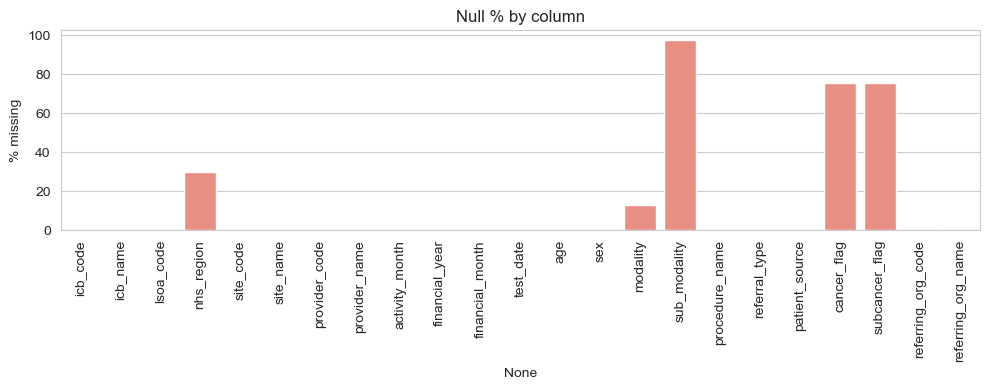

In [7]:
plt.figure(figsize=(10,4))
sns.barplot(
    x=summary.index, y=summary["null_%"],
    color="salmon"
)
plt.xticks(rotation=90); plt.ylabel("% missing"); plt.title("Null % by column")
plt.tight_layout(); plt.show()

5. Type coercion & age-band creation

In [12]:
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df = df[df["age"].notna() & (df["age"]%1==0)]           # keep whole ages only
df["age"] = df["age"].astype(int)

# cut into ONS bands
bins   = age_bands["lower"].tolist() + [np.inf]
labels = age_bands["label"]
df["age_band"] = pd.cut(df["age"], bins=bins, labels=labels, right=True, include_lowest=True)

# normalise sex field
df["sex"] = df["sex"].str.title().str.strip()

print(df[["age","age_band","sex"]].head())

   age age_band     sex
0   63    60-64    Male
1   64    60-64    Male
2   61    60-64  Female
3   79    75-79    Male
4   40    35-39  Female


6. Age-band histogram stacked by sex

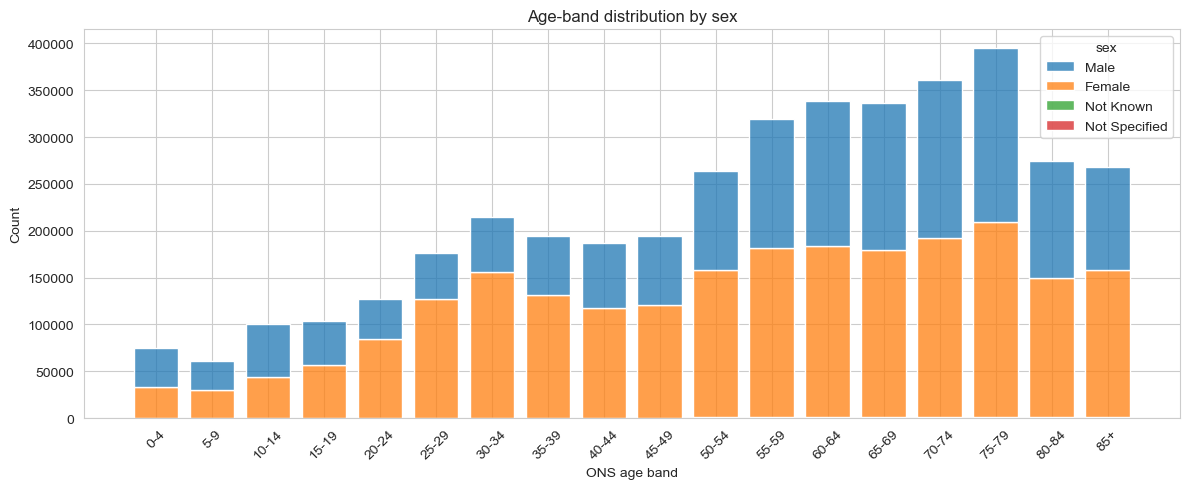

In [13]:
plt.figure(figsize=(12,5))
sns.histplot(
    data=df, x="age_band", hue="sex",
    multiple="stack", shrink=0.8,
    stat="count"
)
plt.title("Age-band distribution by sex")
plt.xlabel("ONS age band"); plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

7. KDE plot (Male vs Female)

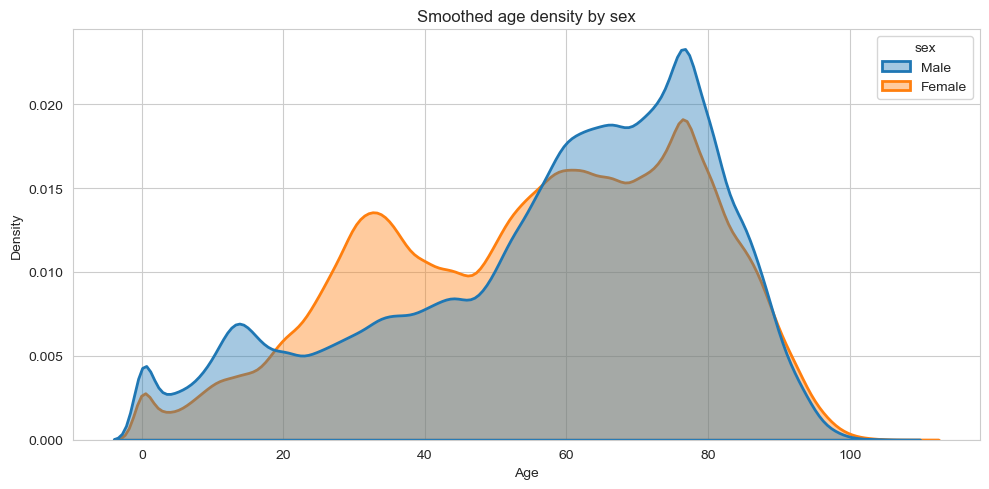

In [14]:
plt.figure(figsize=(10,5))
sns.kdeplot(
    data=df[df["sex"].isin(["Male","Female"])],
    x="age", hue="sex", fill=True, common_norm=False,
    alpha=0.4, linewidth=2
)
plt.title("Smoothed age density by sex")
plt.xlabel("Age"); plt.ylabel("Density")
plt.tight_layout(); plt.show()


8. Clean procedure names & master counts

In [ ]:
df["procedure_clean"] = (
    df["procedure_name"]
      .astype(str)
      .str.strip()
      .str.replace(r"\s*\(\d+\)$","", regex=True)
      .str.lower()
)

proc_counts = (
    df.groupby("procedure_clean", as_index=False)
      .size()
      .rename(columns={"size":"Count"})
      .sort_values("Count", ascending=False)
      .reset_index(drop=True)
)

total_scans = proc_counts["Count"].sum()
proc_counts["% of Total"]   = (proc_counts["Count"]/total_scans*100).round(3)
proc_counts["Cumulative %"] = proc_counts["% of Total"].cumsum().round(3)

display(proc_counts.head())

9. Density of per-procedure counts (log axis)

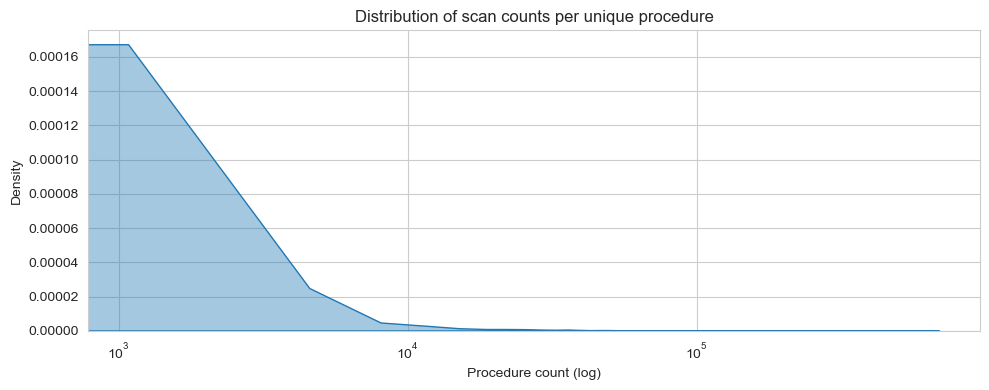

In [16]:
plt.figure(figsize=(10,4))
sns.kdeplot(data=proc_counts, x="Count", fill=True, bw_adjust=0.6, alpha=0.4)
plt.xscale("log")
plt.xlabel("Procedure count (log)"); plt.ylabel("Density")
plt.title("Distribution of scan counts per unique procedure")
plt.tight_layout(); plt.show()


10 a – Cumulative share vs. rank curve

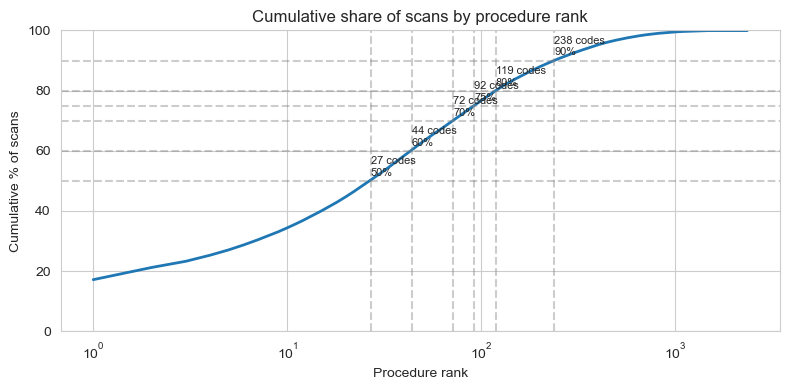

In [17]:
# Visual “elbow” test* – see where the curve starts to flatten.

plt.figure(figsize=(8,4))
x = np.arange(1, len(proc_counts)+1)
y = proc_counts["Cumulative %"]
plt.plot(x, y, lw=2)
for thresh in [50, 60, 70, 75, 80, 90]:
    idx = (y >= thresh).idxmax() + 1
    plt.axhline(thresh, ls="--", color="grey", alpha=0.4)
    plt.axvline(idx,   ls="--", color="grey", alpha=0.4)
    plt.text(idx, thresh+1, f"{idx} codes\n{thresh}%", ha='left', va='bottom', fontsize=8)
plt.xlabel("Procedure rank"); plt.ylabel("Cumulative % of scans")
plt.title("Cumulative share of scans by procedure rank")
plt.ylim(0,100); plt.xscale("log")
plt.tight_layout(); plt.show()

10 b – Quick comparison table  

In [18]:
# How many codes & scans captured at several candidate thresholds.*

benchmarks = [50, 60, 70, 75, 80, 90, 95]
rows = []
for thr in benchmarks:
    mask = proc_counts["Cumulative %"] <= thr
    rows.append({
        "Threshold %": thr,
        "Codes kept":  mask.sum(),
        "Codes dropped": len(proc_counts) - mask.sum(),
        "Scans kept":   proc_counts.loc[mask, "Count"].sum(),
        "Scans kept %": proc_counts.loc[mask, "% of Total"].sum().round(1)
    })
bench_df = pd.DataFrame(rows)
display(bench_df.style
        .set_caption("Core/rare benchmark scenarios")
        .format({"Scans kept":"{:,}", "Scans kept %":"{:.1f}%"}))

,Threshold %,Codes kept,Codes dropped,Scans kept,Scans kept %
0,50,26,2329,"1,977,444",49.6%
1,60,43,2312,"2,388,437",59.9%
2,70,71,2284,"2,788,395",69.9%
3,75,91,2264,"2,985,075",74.8%
4,80,118,2237,"3,186,650",79.9%
5,90,237,2118,"3,589,363",90.0%
6,95,390,1965,"3,789,449",95.0%


11. Define core vs rare (top 70 %)

In [19]:
THRESHOLD = 70
proc_counts["core_flag"] = proc_counts["Cumulative %"] <= THRESHOLD

core = proc_counts[proc_counts["core_flag"]]
rare = proc_counts[~proc_counts["core_flag"]]

print(f"Core procedures: {len(core):,}  •  Rare procedures: {len(rare):,}")
print(f"Core covers {core['% of Total'].sum():.1f}% of all scans")

Core procedures: 71  •  Rare procedures: 2,284
Core covers 69.9% of all scans


In [23]:
# %% -------------------- A  anatomy mapping (same) --------------------
anatomy_map = {
    r"(head|brain|skull|intracranial|pituitary|orbit)": "Head/Brain",
    r"(spine|sacroiliac)":                              "Spine",
    r"(chest|thorax|pulmonary|lung)":                   "Chest",
    r"(abdomen|liver|pancreas|gallbladder)":            "Abdomen",
    r"(pelvis|prostate|rectum|gynaec|uterus)":          "Pelvis",
    r"(knee|hip|shoulder|ankle|foot|wrist)":            "MSK",
    r"(heart|coronary|cardiac|myocardial)":             "Cardiac",
    r"(aorta|angiography|artery|vein)":                 "Vascular",
}

def map_anatomy(text: str) -> str:
    for pat, label in anatomy_map.items():
        if re.search(pat, text):
            return label
    return "Other"

# %% -------------------- B  build core dataframe --------------------
df_core = df[df["procedure_clean"].isin(core["procedure_clean"])].copy()
df_core["anatomy_group"]  = df_core["procedure_clean"].apply(map_anatomy)

df_core["patient_source"] = (
    df_core["patient_source"].astype(str).str.strip()
            .replace({"nan": np.nan}).fillna("Unknown")
)

# %% -------------------- C  OVERALL anatomy mix --------------------
anatomy_mix = (
    df_core["anatomy_group"]
      .value_counts()
      .to_frame("Scans")
      .assign(**{"%": lambda x: (x["Scans"]/x["Scans"].sum()*100).round(2)})
)

display(anatomy_mix.style
        .set_caption("Overall anatomy mix – core scans")
        .format({"Scans":"{:,}", "%":"{:.2f}%"}))

# %% -------------------- D  Patient-source × anatomy cross-tab -------
ps_anatomy = pd.crosstab(
    df_core["patient_source"],
    df_core["anatomy_group"]
)

display(
    ps_anatomy.style
    .set_caption("Core scans – Patient source × anatomy")
    .format("{:,}")
    .background_gradient(axis=1, cmap="Blues")
)



,Scans,%
anatomy_group,,
Chest,"849,282",30.46%
Other,"624,493",22.40%
MSK,"568,981",20.41%
Head/Brain,"239,161",8.58%
Abdomen,"196,601",7.05%
Pelvis,"168,577",6.05%
Spine,"113,082",4.06%
Cardiac,"28,218",1.01%


anatomy_group,Abdomen,Cardiac,Chest,Head/Brain,MSK,Other,Pelvis,Spine
patient_source,,,,,,,,
Accident and Emergency Department (this Health Care Provider),"28,851",795,"220,472","93,926","207,485","67,540","18,185","25,562"
Admitted Patient Care - Day case (this Health Care Provider),"2,268","2,201","6,932","1,665",699,"1,747",641,436
Admitted Patient Care - Inpatient (this Health Care Provider),"68,605","9,751","246,671","63,432","40,793","49,357","15,375","14,990"
GP Direct Access,"50,187",456,"219,827","23,910","163,206","170,848","87,750","30,494"
Other,718,491,"4,641","1,754","14,644","9,635",403,295
Other Health Care Provider,118,16,498,328,450,"11,178",111,376
Outpatient (this Health Care Provider),"45,854","14,508","150,241","54,146","141,704","314,188","46,112","40,929"
